In [76]:
## NÃO CONSIGO USAR!
## 1. CADA VEZ QUE RODO ELE RESULTA UMA QUANTIDADE DE COMUNIDADES UM POUCO DIFERENTE
## 2. NÃO CONSIGO DETERMINAR UMA QUANTIDADE FIXA DE COMUNIDADES (PARA CONSEGUIR COMPARAR COM AS REGIOES)
## 3. NÃO PERMITE GRAFOS DIRECIONADOS

In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import community as community_louvain
from sklearn.metrics.cluster import v_measure_score

UF = 'RJ'
region = 'regional'

In [6]:
mun_df = gpd.read_file("../data/%s/%s_Municipios_2021.dbf"%(UF, UF), encoding = "utf-8")
mun_df['code'] = np.array([item[:-1] for item in np.array(mun_df.CD_MUN)]).astype('int') # trim last char

# import the municipality-region-macroregion relations
reg_macro_df = pd.read_csv("../data/%s/reg_macro_table.csv"%UF)

# import the flow data for each available year
df = pd.read_csv("../data/%s/mun_sih_flow.csv"%UF)

# create/open file to save the similarity index
#if(exists("../data/%s/reg_similarity.csv"%UF)):
#    index_df = pd.read_csv("../data/%s/reg_similarity.csv"%UF, index_col='year')
#else:
index_df = pd.DataFrame({'year': df['year'].unique(),
                         'all': ['']*len(df['year'].unique())}).set_index('year')

communities_gdf = gpd.GeoDataFrame({'year': [''],
                                    'geometry': ['']}, index=[0]) 

In [9]:
year = 2019

# for year in df['year'].unique():
available_year = year
if year < 2011: available_year = 2011
if year > 2017: available_year = 2017

# get available municipality-region-macroregion relations and the number of health regions/macroregions
if(region=='regional'): 
    year_reg_macro_df = reg_macro_df[reg_macro_df['year']==available_year]
    regions_num = len(year_reg_macro_df['region'].unique())
else: 
    year_reg_macro_df = reg_macro_df[reg_macro_df['year']==2020]
    regions_num = len(year_reg_macro_df['macroregion'].unique())

year_df = df[df['year']==year]

year_df = year_df[['from', 'to', 'hospitalizations']].groupby(
    by = ['from', 'to'], as_index = False).sum()

year_df['from_code'] = year_df['from'].map(lambda x: eval(x)['code'])
year_df['to_code'] = year_df['to'].map(lambda x: eval(x)['code'])

graph = nx.from_pandas_edgelist(year_df, source = 'from_code', target = 'to_code',
                edge_attr = 'hospitalizations',create_using = nx.Graph())

partition = community_louvain.best_partition(graph, weight='hospitalizations')
print(max(partition.values()) + 1, 'communities')

# dendo = community_louvain.generate_dendrogram(G, weight='hospitalizations')

# partition = community_louvain.partition_at_level(dendo, 0)

# print(max(partition.values()) + 1, 'communities')

23 communities


In [12]:
louvain_result = pd.DataFrame(partition.items(), columns=['mun_code', 'community'])
mun_df = mun_df.merge(louvain_result, how = 'left', left_on = ['code'], right_on = ['mun_code'])

mun_df[['code', 'community']]

code  community
0   330010         19
1   330015          2
2   330020         15
3   330022         21
4   330023         15
..     ...        ...
87  330600         21
88  330610          8
89  330615          2
90  330620         17
91  330630         13

[92 rows x 2 columns]

In [13]:
mun_df[['code', 'community']].to_csv("./louvain_result_%d.csv"%year, index=False)

----------

In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import community as community_louvain
from sklearn.metrics.cluster import v_measure_score

UF = 'RJ'
region = 'regional'

mun_df = gpd.read_file("../data/%s/%s_Municipios_2021.dbf"%(UF, UF), encoding = "utf-8")
mun_df['code'] = np.array([item[:-1] for item in np.array(mun_df.CD_MUN)]).astype('int') # trim last char

# import the municipality-region-macroregion relations
reg_macro_df = pd.read_csv("../data/%s/reg_macro_table.csv"%UF)

# import the flow data for each available year
df = pd.read_csv("../data/%s/mun_sih_flow.csv"%UF)

# create/open file to save the similarity index
#if(exists("../data/%s/reg_similarity.csv"%UF)):
#    index_df = pd.read_csv("../data/%s/reg_similarity.csv"%UF, index_col='year')
#else:
index_df = pd.DataFrame({'year': df['year'].unique(),
                         'all': ['']*len(df['year'].unique())}).set_index('year')

communities_gdf = gpd.GeoDataFrame({'year': [''],
                                    'geometry': ['']}, index=[0]) 

for year in range(1994, 2021):

    # for year in df['year'].unique():
    available_year = year
    if year < 2011: available_year = 2011
    if year > 2017: available_year = 2017

    # get available municipality-region-macroregion relations and the number of health regions/macroregions
    if(region=='regional'): 
        year_reg_macro_df = reg_macro_df[reg_macro_df['year']==available_year]
        regions_num = len(year_reg_macro_df['region'].unique())
    else: 
        year_reg_macro_df = reg_macro_df[reg_macro_df['year']==2020]
        regions_num = len(year_reg_macro_df['macroregion'].unique())

    year_df = df[df['year']==year]

    year_df = year_df[['from', 'to', 'hospitalizations']].groupby(
        by = ['from', 'to'], as_index = False).sum()

    year_df['from_code'] = year_df['from'].map(lambda x: eval(x)['code'])
    year_df['to_code'] = year_df['to'].map(lambda x: eval(x)['code'])

    graph = nx.from_pandas_edgelist(year_df, source = 'from_code', target = 'to_code',
                    edge_attr = 'hospitalizations',create_using = nx.Graph())

    partition = community_louvain.best_partition(graph, weight='hospitalizations')
    print(year, max(partition.values()) + 1, 'communities')

    louvain_result = pd.DataFrame(partition.items(), columns=['mun_code', 'community'])
    mun_df.merge(louvain_result, how = 'left', left_on = ['code'], right_on = ['mun_code'])[['code', 'community']].to_csv("./louvain_result_%d.csv"%year, index=False)

1994 22 communities
1995 22 communities
1996 22 communities
1997 22 communities
1998 21 communities
1999 17 communities
2000 18 communities
2001 21 communities
2002 23 communities
2003 24 communities
2004 20 communities
2005 23 communities
2006 25 communities
2007 22 communities
2008 24 communities
2009 23 communities
2010 23 communities
2011 23 communities
2012 26 communities
2013 25 communities
2014 23 communities
2015 26 communities
2016 22 communities
2017 24 communities
2018 22 communities
2019 23 communities
2020 22 communities


------------------------

In [17]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

G = nx.karate_club_graph()

4 communities


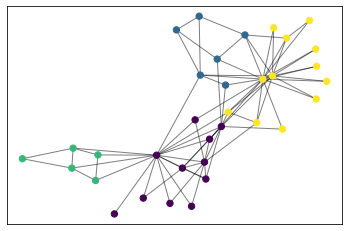

In [45]:
# compute the best partition
partition = community_louvain.best_partition(G)
print(max(partition.values()) + 1, 'communities')

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                        cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

4 communities


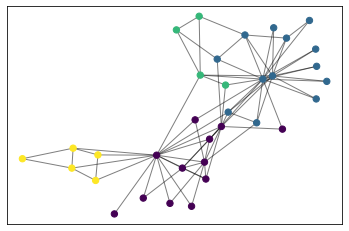

In [46]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

dendo = community_louvain.generate_dendrogram(G)

partition = community_louvain.partition_at_level(dendo, 1)

print(max(partition.values()) + 1, 'communities')
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                        cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()